# Deep Convolution Network - Image Recognition - CIFS 100 


In [ ]:

%pip install -q keras-tuner numpy imageio pydot tensorflow-gpu==2.9.1 keras


## Import all Modules and Configure GPU

In [2]:
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow.keras.datasets.cifar100


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        mixed_precision.set_global_policy('mixed_float16')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2022-06-05 07:35:30.337261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 07:35:30.360131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 07:35:30.360299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


## Setup DataSet

In [5]:

def loadDataCifar100():
    (train_images, train_labels), (test_images,
                                   test_labels) = tensorflow.keras.datasets.cifar100.load_data(label_mode='fine'
                                                                                               )

    class_names = [
        "apple",
        "aquarium_fish",
        "baby",
        "bear",
        "beaver",
        "bed",
        "bee",
        "beetle",
        "bicycle",
        "bottle",
        "bowl",
        "boy",
        "bridge",
        "bus",
        "butterfly",
        "camel",
        "can",
        "castle",
        "caterpillar",
        "cattle",
        "chair",
        "chimpanzee",
        "clock",
        "cloud",
        "cockroach",
        "couch",
        "crab",
        "crocodile",
        "cup",
        "dinosaur",
        "dolphin",
        "elephant",
        "flatfish",
        "forest",
        "fox",
        "girl",
        "hamster",
        "house",
        "kangaroo",
        "keyboard",
        "lamp",
        "lawn_mower",
        "leopard",
        "lion",
        "lizard",
        "lobster",
        "man",
        "maple_tree",
        "motorcycle",
        "mountain",
        "mouse",
        "mushroom",
        "oak_tree",
        "orange",
        "orchid",
        "otter",
        "palm_tree",
        "pear",
        "pickup_truck",
        "pine_tree",
        "plain",
        "plate",
        "poppy",
        "porcupine",
        "possum",
        "rabbit",
        "raccoon",
        "ray",
        "road",
        "rocket",
        "rose",
        "sea",
        "seal",
        "shark",
        "shrew",
        "skunk",
        "skyscraper",
        "snail",
        "snake",
        "spider",
        "squirrel",
        "streetcar",
        "sunflower",
        "sweet_pepper",
        "table",
        "tank",
        "telephone",
        "television",
        "tiger",
        "tractor",
        "train",
        "trout",
        "tulip",
        "turtle",
        "wardrobe",
        "whale",
        "willow_tree",
        "wolf",
        "woman",
        "worm"]

    TrainX = np.concatenate((train_images, test_images))
    TrainY = np.squeeze(np.concatenate((train_labels, test_labels)))

    TrainX = TrainX / 255.0

    return TrainX, TrainY, class_names


In [6]:

EPOCH = 128
BUFFER_SIZE = 192
BATCH_SIZE = 256

trainX, trainY, classes = loadDataCifar100()
IMAGE_SIZE = trainX[0].shape


## Show Example of DataSet

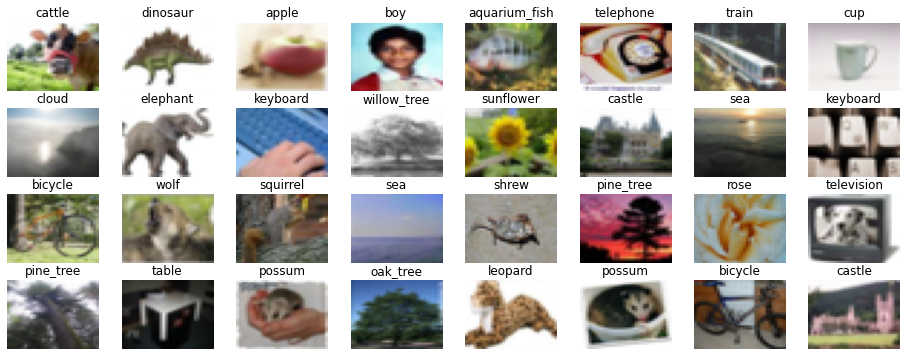

In [7]:
fig = plt.figure(figsize=(16, 6))
nrImage = 4 * 8
for index, (image, label) in enumerate(zip(trainX[0:nrImage], trainY[0:nrImage])):
    plt.subplot(4, 8, (index + 1))
    plt.title(label=str.format("{0}", classes[label]))

    plt.imshow(X=image.astype(dtype='float32'), cmap=plt.cm.gray, aspect='auto')
    plt.axis("off")
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show(block=False)


In [8]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


## Create Network with Hyperparameter
By using hyperparameter, a set of possible neuron network configuration can be setup. This allows to find network that are more optimal.

SparseCategoricalCrossentropy is used as the loss function. But also that it generates one-hot vector from an integer value that represents the categorical.

In [9]:

def generate_cnn_builder(hp, input, output):
    cnn_model = tf.keras.Sequential()
    #
    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    hp_kernel_filter_size_l0 = hp.Int(
        'kernel_filter_size_0', min_value=32, max_value=512, step=32)
    hp_kernel_filter_size_l1 = hp.Int(
        'kernel_filter_size_1', min_value=32, max_value=512, step=32)

    hp_strides_size_l0 = hp.Int(
        'hp_strides_size_l0', min_value=1, max_value=2, step=1)
    hp_strides_size_l1 = hp.Int(
        'hp_strides_size_l1', min_value=1, max_value=2, step=1)

    hp_kernel_size_l0 = hp.Int(
        'hp_kernel_size_l0', min_value=3, max_value=7, step=2)
    hp_kernel_size_l1 = hp.Int(
        'hp_kernel_size_l1', min_value=3, max_value=7, step=2)

    hp_max_pooling_size_l0 = hp.Int(
        'max_pooling_l0', min_value=1, max_value=3, step=1)
    hp_max_pooling_size_l1 = hp.Int(
        'max_pooling_l1', min_value=1, max_value=3, step=1)

    cnn_model.add(
        layers.Conv2D(filters=hp_kernel_filter_size_l0, kernel_size=(3, 3), strides=hp_strides_size_l0,
                      kernel_initializer=kernel_init, activation='relu',
                      padding='same',
                      input_shape=input))
    cnn_model.add(layers.MaxPooling2D(pool_size=hp_max_pooling_size_l0))

    cnn_model.add(
        layers.Conv2D(filters=hp_kernel_filter_size_l1, kernel_size=(3, 3), strides=hp_strides_size_l1,
                      activation='relu', kernel_initializer=kernel_init))
    cnn_model.add(layers.MaxPooling2D(pool_size=hp_max_pooling_size_l1))

    cnn_model.add(layers.Flatten())

    hp_units = hp.Int('dense0_units', min_value=32, max_value=512, step=32)
    cnn_model.add(layers.Dense(units=hp_units, kernel_initializer=kernel_init))
    cnn_model.add(layers.Dense(units=output))

    cnn_model.summary()

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss=keras.losses.SparseCategoricalCrossentropy(
                          from_logits=True),
                      metrics=['accuracy'])

    return cnn_model


## Training
First the dataset is split into training and test data.

kt.Hyperband is used as the hyperparameter manager, where the model_builder is the function that will construct the convolutional network.

tuner.search will search the whole hyperparameter space and select the one that is best, and to prevent it having to run all epoch, an EarlyStopping is used to valdiate if the model performance good or not in the early stage of the learning.

In [10]:
# Neuron network input and output.
image_shape = trainX[0].shape
num_classes_output = len(classes)

train_X, test_X, train_y, test_y = train_test_split(
    trainX, trainY, shuffle=True, test_size=0.25)

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  ' + str(test_X.shape))
print('Y_test:  ' + str(test_y.shape))

def model_builder(hp):
    model = generate_cnn_builder(hp, image_shape, num_classes_output)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=3,
                     directory='cache',
                     project_name=str.format('cnn - {0}', "cifs-100"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_X, train_y, validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE,
             callbacks=[stop_early], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)


X_train: (45000, 32, 32, 3)
Y_train: (45000,)
X_test:  (15000, 32, 32, 3)
Y_test:  (15000,)
INFO:tensorflow:Reloading Oracle from existing project cache/cnn - cifs-100/oracle.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten

2022-06-05 07:35:32.217905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-05 07:35:32.218615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 07:35:32.218795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 07:35:32.218907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 288)       8064      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 288)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 352)       912736    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 352)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8800)              0         
                                                                 
 dense (Dense)               (None, 192)               1

## Training the Best Model
Now the best model that was selected is constructed and trained on.

In [11]:
cnn_model = tuner.hypermodel.build(best_hps)
cnn_model.summary()
cnn_model_history = cnn_model.fit(train_X, train_y, epochs=EPOCH, batch_size=BATCH_SIZE)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 288)       8064      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 288)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 352)       912736    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 352)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8800)              0         
                                                                 
 dense_2 (Dense)             (None, 192)              

2022-06-05 07:35:35.569681: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-06-05 07:35:36.418416: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-05 07:35:36.619565: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


  3/176 [..............................] - ETA: 7s - loss: 4.9765 - accuracy: 0.0104  

2022-06-05 07:35:37.025414: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-06-05 07:35:37.025452: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


176/176 [==============================] - 11s 48ms/step - loss: 4.0015 - accuracy: 0.1125
Epoch 2/128
176/176 [==============================] - 8s 46ms/step - loss: 3.2603 - accuracy: 0.2389
Epoch 3/128
176/176 [==============================] - 8s 47ms/step - loss: 2.9233 - accuracy: 0.3006
Epoch 4/128
176/176 [==============================] - 8s 46ms/step - loss: 2.6868 - accuracy: 0.3485
Epoch 5/128
176/176 [==============================] - 8s 47ms/step - loss: 2.5050 - accuracy: 0.3866
Epoch 6/128
176/176 [==============================] - 8s 47ms/step - loss: 2.3485 - accuracy: 0.4201
Epoch 7/128
176/176 [==============================] - 8s 45ms/step - loss: 2.2052 - accuracy: 0.4510
Epoch 8/128
176/176 [==============================] - 7s 41ms/step - loss: 2.0656 - accuracy: 0.4822
Epoch 9/128
176/176 [==============================] - 7s 41ms/step - loss: 1.9499 - accuracy: 0.5065
Epoch 10/128
176/176 [==============================] - 7s 41ms/step - loss: 1.8376 - accurac

In [ ]:
cnn_model.save("dc-network-cifs100.h5")

## Final Result

In [12]:
val_acc_per_epoch = cnn_model_history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: {0}'.format(best_epoch,))

cnn_model.evaluate(test_X, test_y, verbose=2)


Best epoch: 120
469/469 - 1s - loss: 6.0142 - accuracy: 0.3928 - 1s/epoch - 3ms/step


[6.014215469360352, 0.3928000032901764]

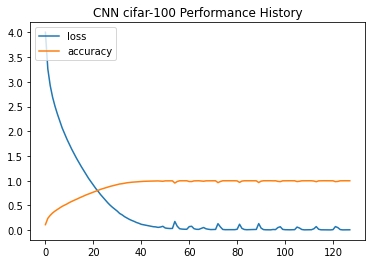

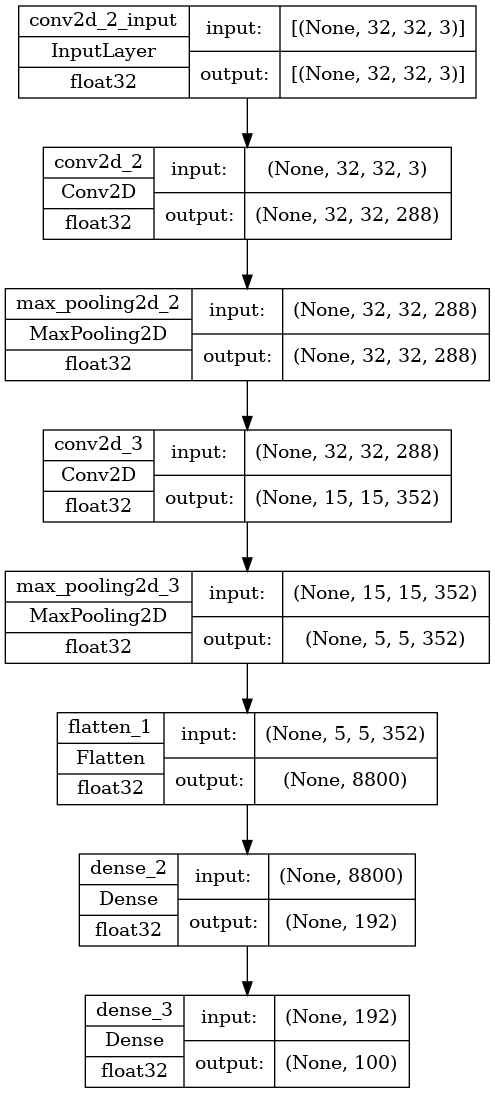

<Figure size 432x288 with 0 Axes>

In [13]:
plotCostHistory(cnn_model_history.history, title=str.format(
    "CNN {0} Performance History", "cifar-100"))

tf.keras.utils.plot_model(
    cnn_model, to_file=str.format('cnn_{0}_model.png', "cifar-100"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)


In [14]:
cnn_model.save(str.format("cnn_{0}.h5", "cifar-100"))
